In [1]:
import pandas as pd
from statsmodels.stats.proportion import proportion_confint as ci
from natsort import natsorted
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from matplotlib.animation import FuncAnimation

In [2]:
def get_clean_cape_dataframe(filepath):
    """
    read the cleaned data as dataframe
    Args:
        filepath: str
        the location of the csv file
    Returns:
        dataframe
    """
    df = pd.read_csv(filepath)
    return df

In [3]:
def get_depts_and_courses_dictionary(df):
    """
    get all courses for departments
    Args:
        df: dataframe

    Returns:
        depths_courses: dict

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_depts_and_courses_dictionary(df)
        depths_courses = {'AAS': ['10', '11', '170', '190'], 'ANAR': ['100', '114', '115', '116', '135', '135S', '143']}

    """
    df = (df['Course_ID'].str.split(expand=True)
          .rename(columns={0: 'dept', 1: 'course'})
          .drop_duplicates())

    depts = natsorted(df.dept.unique())
    df = df.set_index(['dept', 'course']).sort_index()

    depts_courses = {dept: natsorted(df.loc[dept].index) for dept in depts}

    return depts_courses

In [4]:
def get_global_avg_time(df):
    """
    return the average time and stand deviation for all courses
    """
    gb = df[['Course_ID', 'time']]
    global_average = float(gb.mean())
    global_sd = float(gb.std())
    
    return global_average, global_sd
    
def get_time_df(df, global_average, global_sd):
    """
    group the dataframe using the Course_ID, the average spending time for a particular course between different terms is calculated
    compare the time with other courses
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_time_df(df)
           
        new_df:
            Course_ID  time  depart_avg_time  global_avg_time  depart_time_diff  global_time_diff              
        0       AAS 10  4.07             3.75         5.494174              0.32         -1.424174
        1      AAS 170  3.61             3.75         5.494174             -0.14         -1.884174  
        2      AAS 190  2.93             3.75         5.494174             -0.82         -2.564174  
        3     ANAR 100  3.17             4.10         5.494174             -0.93         -2.324174  
        4     ANAR 116  3.59             4.10         5.494174             -0.51         -1.904174  
    """

    df = df[['Course_ID', 'time']]
    # groupby to get average time for same courses in different quarters
    gb = df[['time', 'Course_ID']].groupby('Course_ID').mean().round(2)
    # print(gb)

    # for departments
    depths_time = {}
    depths_courses = get_depts_and_courses_dictionary(df)
    for dept, courses in depths_courses.items():
        times = []
        for course in courses:
            mask = df['Course_ID'].str.startswith(dept + ' ' + course)
            if mask.any():
                times.extend(df.loc[mask, 'time'])

        if times:
            average_time = np.mean(times)
            std_deviation = np.std(times)
            depths_time[dept] = (average_time, std_deviation)

    # for all courses
#     global_average = float(gb.mean())
#     global_sd = float(gb.std())

    df['department'] = df['Course_ID'].str.split().str[0]
    df['depart_avg_time'] = df['department'].map(lambda x: depths_time[x][0] if x in depths_time else None)

    gb = df.groupby('Course_ID').mean().round(2).reset_index()
    gb['global_avg_time'] = global_average
    gb['depart_time_diff'] = gb['time'] - gb['depart_avg_time']
    gb['global_time_diff'] = gb['time'] - global_average

    return gb

In [5]:
def get_grade_dev_df(df):
    """
    group the dataframe using the Course_ID, the average expected and actual gpa for a particular course between different terms is calculated
    compare the expected gpa and actual gpa
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_grade_dev_df(df)

        new_df:
                Course_ID  expected_gpa  actual_gpa   dev
            0       AAS 10          3.79        3.56 -0.23
            1      AAS 170          3.89        3.68 -0.21
            2      AAS 190          3.86        4.00  0.14
            3     ANAR 100          3.33        3.30 -0.03
            4     ANAR 116          3.70        3.35 -0.35
            ...        ...           ...         ...   ...
            1205   VIS 70N          3.78        3.60 -0.18
            1206    VIS 80          3.84        3.82 -0.02
            1207  WCWP 100          3.54        3.49 -0.05
            1208  WCWP 10A          3.73        3.65 -0.08
            1209  WCWP 10B          3.55        3.50 -0.05
                            
    """
    df = df[['Course_ID', 'expected_gpa', 'actual_gpa']]

    # groupby to get the mean grade and round to 2 decimal places
    gb = df.groupby('Course_ID').mean().round(2).reset_index()
    gb['dev'] = gb['actual_gpa'] - gb['expected_gpa']

    return gb


In [6]:
def get_class_rmd_df(df):
    """
    group the dataframe using the Course_ID, the average class recommendation ratio for a particular course between different terms is calculated
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_class_rmd_df(df)

        new_df:
             Course_ID  rmd_class
        0       AAS 10      85.68
        1       AAS 11      93.50
        2      AAS 170      94.45
        3      AAS 190     100.00
        4     ANAR 100     100.00
        ...        ...        ...
        2447    VIS 84      80.55
        2448     VIS 9      80.60
        2449  WCWP 100      92.66
        2450  WCWP 10A      91.66
        2451  WCWP 10B      90.33
    """
    df = df[['Course_ID', 'rmd_class']]
    # groupby to get the mean course recommendation ratio and round to 2 decimal places
    gb = df.groupby(['Course_ID']).mean().round(2).reset_index()
    
    return gb

In [7]:
def get_instr_rmd_df(df):
    """
    group the dataframe using the Course_ID, the average instructor recommendation ratio for a particular course between different terms is calculated
    Args:
        df
    Returns:
        gb: dataframe

    Examples:
    --------
        >>> df = get_clean_cape_dataframe(filepath)
        >>> get_instr_rmd_df(df):

        new_df:
                Course_ID                        instr  rmd_instr
        0       AAS 10    Butler, Elizabeth Annette      88.63
        1      AAS 170    Butler, Elizabeth Annette      88.90
        2      AAS 190  Puritty, Chandler Elizabeth     100.00
        3     ANAR 100                Fortier, Jana     100.00
        4     ANAR 116            Shtienberg, Gilad     100.00
        ...        ...                          ...        ...
        2256  WCWP 10A              Savage, Sarah S     100.00
        2257  WCWP 10A                Susi, Natalie      97.10
        2258  WCWP 10B            Gagnon, Jeffrey C      95.80
        2259  WCWP 10B           Tocki, Jasmine Rae     100.00
        2260  WCWP 10B         Welji, Haleema Nazir      93.30
    """
    df = df[['Course_ID', 'instr', 'rmd_instr']]

    # groupby to get the mean grade and round to 2 decimal places
    gb = df.groupby(['Course_ID','instr']).mean().round(2).reset_index()
    
    return gb

In [8]:
df = get_clean_cape_dataframe('data_clean.csv')

In [9]:
df

instr  term  enroll  evals  rmd_class  rmd_instr  \
0      Butler, Elizabeth Annette  SP23      66     48       93.5      100.0   
1      Butler, Elizabeth Annette  SP23      20      7      100.0      100.0   
2              Shtienberg, Gilad  SP23      26      6      100.0       83.3   
3          Braswell, Geoffrey E.  SP23      22      9      100.0      100.0   
4            Hrvoj Mihic, Branka  SP23      22      4      100.0      100.0   
...                          ...   ...     ...    ...        ...        ...   
15400   Blomstedt, Elizabeth Ann  SP19      20      6      100.0      100.0   
15401       McCleary, Keith Long  SP19      20     19       84.2       94.4   
15402              Young, Mark T  SP19      20      8       75.0       87.5   
15403          Gagnon, Jeffrey C  SP19     150    126       76.9       91.5   
15404          Gagnon, Jeffrey C  SP19     633    337       66.7       84.9   

       time Course_ID                         Course_Name expected_grade  \
0      2.80    AAS 10  Intro/African-American Studies (A)             A-   
1      2.50   AAS 170            Legacies of Research (A)             A-   
2      3.83  ANAR 115   Coastal Geomorphology/Environ (A)             B+   
3      5.17  ANAR 155  Stdy Abrd: Ancient Mesoamerica (A)              A   
4      2.50  ANBI 111                 Human Evolution (A)              A   
...     ...       ...                                 ...            ...   
15400  4.50  WCWP 100                Academic Writing (B)             B+   
15401  8.39  WCWP 100                Academic Writing (C)             B-   
15402  8.00  WCWP 100                Academic Writing (F)              B   
15403  5.21  WCWP 10A            The Writing Course A (0)              B   
15404  4.16  WCWP 10B            The Writing Course B (0)             B+   

       expected_gpa actual_grade  actual_gpa  
0              3.84           B+        3.67  
1              3.86           A-        3.92  
2              3.50            B        3.07  
3              4.00            A        4.00  
4              4.00           B-        2.95  
...             ...          ...         ...  
15400          3.60           B+        3.42  
15401          2.95            B        3.17  
15402          3.13           B+        3.34  
15403          3.11            B        3.21  
15404          3.34           B+        3.36  

[15405 rows x 13 columns]

## Input the weights

Please provide your preferences for each category on a scale of 1 to 10, separated by spaces

(GPA, Time Spent, Exp vs True GPA, % Rec Course, % Rec Prof):

For example, enter: 10 10 5 5 5

In [10]:
user_input = input("Enter ratings separated by spaces: ")
ratings = list(map(int, user_input.split()))

def weights(ratings):
    '''
    Calculate weights based on rankings
    
    Args:
        ratings: input ratings
    
    Return:
        list: ration of ratings to sum of all ratings
    
    '''
    weights = []
    for i in ratings:
        weights.append(i/sum(ratings))
    return weights
        

Enter ratings separated by spaces: 10 10 5 5 5


In [11]:
weights = weights(ratings)
print(weights)

[0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285]


## Input the desired quarters

Please input a space seperated list of desired quarters using the corresponding numbers:

1. Fall
2. Winter
3. Spring
4. Summer Session 1
5. Summer Session 2

For example, entering `1 2 3` will select Fall, Winter, and Spring.

In [12]:
quarters = list(map(int, input("Enter quarter numbers separated by spaces: ").split(' ')))
quarters

Enter quarter numbers separated by spaces: 1 2


[1, 2]

## Input the desired depeartments

Please input a space seperated list of desired quarters 
Ex: ECE CSE

In [13]:
user_input = input("Enter department names separated by spaces: ")

depts = user_input.split()

depts

Enter department names separated by spaces: AAS ANAR ANBI ANSC ANTH AWP BENG BIBC BICD BIEB BILD BIMM BIPN BISP CAT CCS CENG CGS CHEM CHIN COGS COMM CSE CSS DOC DSC DSGN ECE ECON EDS ENG ENVR ERC ESYS ETHN FMPH GLBH GSS HDP HDS HIAF HIEA HIEU HIGL HILA HILD HINE HISC HITO HIUS HMNR HUM INTL JAPN JWSP LATI LAWS LIGN LIHL LTAM LTCH LTCS LTEA LTEN LTEU LTFR LTGK LTGM LTIT LTKO LTLA LTRU LTSP LTTH LTWL LTWR MAE MATH MGT MMW MUS NANO PHIL PHYS POLI PSYC RELI SE SIO SOCI SYN TDAC TDDE TDDM TDDR TDGE TDHT TDMV TDPF TDPR TDPW TDTR TWS USP VIS WCWP


['AAS',
 'ANAR',
 'ANBI',
 'ANSC',
 'ANTH',
 'AWP',
 'BENG',
 'BIBC',
 'BICD',
 'BIEB',
 'BILD',
 'BIMM',
 'BIPN',
 'BISP',
 'CAT',
 'CCS',
 'CENG',
 'CGS',
 'CHEM',
 'CHIN',
 'COGS',
 'COMM',
 'CSE',
 'CSS',
 'DOC',
 'DSC',
 'DSGN',
 'ECE',
 'ECON',
 'EDS',
 'ENG',
 'ENVR',
 'ERC',
 'ESYS',
 'ETHN',
 'FMPH',
 'GLBH',
 'GSS',
 'HDP',
 'HDS',
 'HIAF',
 'HIEA',
 'HIEU',
 'HIGL',
 'HILA',
 'HILD',
 'HINE',
 'HISC',
 'HITO',
 'HIUS',
 'HMNR',
 'HUM',
 'INTL',
 'JAPN',
 'JWSP',
 'LATI',
 'LAWS',
 'LIGN',
 'LIHL',
 'LTAM',
 'LTCH',
 'LTCS',
 'LTEA',
 'LTEN',
 'LTEU',
 'LTFR',
 'LTGK',
 'LTGM',
 'LTIT',
 'LTKO',
 'LTLA',
 'LTRU',
 'LTSP',
 'LTTH',
 'LTWL',
 'LTWR',
 'MAE',
 'MATH',
 'MGT',
 'MMW',
 'MUS',
 'NANO',
 'PHIL',
 'PHYS',
 'POLI',
 'PSYC',
 'RELI',
 'SE',
 'SIO',
 'SOCI',
 'SYN',
 'TDAC',
 'TDDE',
 'TDDM',
 'TDDR',
 'TDGE',
 'TDHT',
 'TDMV',
 'TDPF',
 'TDPR',
 'TDPW',
 'TDTR',
 'TWS',
 'USP',
 'VIS',
 'WCWP']

In [14]:
maps = {1: 'FA', 2:'WI', 3:'SP', 4: 'S1', 5:'S2'}

# maps quarters to string name and slices df based on quarters
quarter_str = '|'.join([maps[q] for q in quarters])
df2 = df[df['term'].str.contains(quarter_str)].reset_index(drop=True)
df2

instr  term  enroll  evals  rmd_class  rmd_instr  \
0     Butler, Elizabeth Annette  WI23      65     46       93.5       93.3   
1             Shtienberg, Gilad  WI23      27      9      100.0      100.0   
2         Braswell, Geoffrey E.  WI23      24     15      100.0       92.9   
3        Rodriguez, Eric Andrew  WI23      41     23      100.0      100.0   
4                    Non, Amy L  WI23      71     45       84.4       81.8   
...                         ...   ...     ...    ...        ...        ...   
8435                 Cho, Erica  FA19     127     78       81.6       70.7   
8436   Tonies, Joshua Vanjaymes  FA19     115     96       97.9       98.9   
8437       McCleary, Keith Long  FA19      20     20       95.0      100.0   
8438          Gagnon, Jeffrey C  FA19     697    398       74.3       86.9   
8439          Gagnon, Jeffrey C  FA19      87     52       81.6       97.4   

      time Course_ID                        Course_Name expected_grade  \
0     4.15    AAS 11  Intro Black Diasporic Studies (A)             A-   
1     3.61  ANAR 116         Sea Level ChangeIsrael (A)              A   
2     3.42  ANAR 135      Ancient Mediterranean Civ (A)              A   
3     4.07  ANAR 164         Underwater Archaeology (A)             A-   
4     4.28  ANBI 130          Biology of Inequality (A)             B+   
...    ...       ...                                ...            ...   
8435  6.47   VIS 70N          Introduction to Media (A)             B+   
8436  9.43    VIS 80   Introduction to Studio Major (A)             B+   
8437  8.70  WCWP 100               Academic Writing (B)              B   
8438  4.77  WCWP 10A           The Writing Course A (0)             B+   
8439  5.70  WCWP 10B           The Writing Course B (0)              B   

      expected_gpa actual_grade  actual_gpa  
0             3.84           A-        3.71  
1             4.00           B+        3.62  
2             4.00           A-        3.99  
3             3.80           B+        3.63  
4             3.42           B+        3.41  
...            ...          ...         ...  
8435          3.64           B+        3.59  
8436          3.67           B+        3.65  
8437          3.00            B        3.28  
8438          3.39            B        3.28  
8439          3.15            B        3.10  

[8440 rows x 13 columns]

In [15]:
df_quarter = df2[df2['Course_ID'].str.contains('|'.join(depts))].reset_index(drop=True)
df_quarter

instr  term  enroll  evals  rmd_class  rmd_instr  \
0     Butler, Elizabeth Annette  WI23      65     46       93.5       93.3   
1             Shtienberg, Gilad  WI23      27      9      100.0      100.0   
2         Braswell, Geoffrey E.  WI23      24     15      100.0       92.9   
3        Rodriguez, Eric Andrew  WI23      41     23      100.0      100.0   
4                    Non, Amy L  WI23      71     45       84.4       81.8   
...                         ...   ...     ...    ...        ...        ...   
8435                 Cho, Erica  FA19     127     78       81.6       70.7   
8436   Tonies, Joshua Vanjaymes  FA19     115     96       97.9       98.9   
8437       McCleary, Keith Long  FA19      20     20       95.0      100.0   
8438          Gagnon, Jeffrey C  FA19     697    398       74.3       86.9   
8439          Gagnon, Jeffrey C  FA19      87     52       81.6       97.4   

      time Course_ID                        Course_Name expected_grade  \
0     4.15    AAS 11  Intro Black Diasporic Studies (A)             A-   
1     3.61  ANAR 116         Sea Level ChangeIsrael (A)              A   
2     3.42  ANAR 135      Ancient Mediterranean Civ (A)              A   
3     4.07  ANAR 164         Underwater Archaeology (A)             A-   
4     4.28  ANBI 130          Biology of Inequality (A)             B+   
...    ...       ...                                ...            ...   
8435  6.47   VIS 70N          Introduction to Media (A)             B+   
8436  9.43    VIS 80   Introduction to Studio Major (A)             B+   
8437  8.70  WCWP 100               Academic Writing (B)              B   
8438  4.77  WCWP 10A           The Writing Course A (0)             B+   
8439  5.70  WCWP 10B           The Writing Course B (0)              B   

      expected_gpa actual_grade  actual_gpa  
0             3.84           A-        3.71  
1             4.00           B+        3.62  
2             4.00           A-        3.99  
3             3.80           B+        3.63  
4             3.42           B+        3.41  
...            ...          ...         ...  
8435          3.64           B+        3.59  
8436          3.67           B+        3.65  
8437          3.00            B        3.28  
8438          3.39            B        3.28  
8439          3.15            B        3.10  

[8440 rows x 13 columns]

In [16]:
# Convert rows to numeric
df_quarter['actual_gpa'] = pd.to_numeric(df_quarter['actual_gpa'], errors='coerce')
df_quarter['rmd_class'] = pd.to_numeric(df_quarter['rmd_class'], errors='coerce')
df_quarter['rmd_instr'] = pd.to_numeric(df_quarter['rmd_instr'], errors='coerce')
df_quarter['time'] = pd.to_numeric(df_quarter['time'], errors='coerce')
df_quarter['gpa_diff'] = pd.to_numeric(df_quarter['actual_gpa'], errors='coerce') - pd.to_numeric(df_quarter['expected_gpa'], errors='coerce')

# Calculates the percentile of each entry based on other entries in filtered dataframe
df_quarter['actual_gpa_percentile'] = df_quarter['actual_gpa'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['actual_gpa'], x))
df_quarter['rmd_class_percentile'] = df_quarter['rmd_class'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['rmd_class'], x))
df_quarter['rmd_instr_percentile'] = df_quarter['rmd_instr'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['rmd_instr'], x))
df_quarter['time_percentile'] = df_quarter['time'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['time'], x))
df_quarter['gpa_diff_percentile'] = df_quarter['gpa_diff'].apply(lambda x: scipy.stats.percentileofscore(df_quarter['gpa_diff'], x))


df_quarter

instr  term  enroll  evals  rmd_class  rmd_instr  \
0     Butler, Elizabeth Annette  WI23      65     46       93.5       93.3   
1             Shtienberg, Gilad  WI23      27      9      100.0      100.0   
2         Braswell, Geoffrey E.  WI23      24     15      100.0       92.9   
3        Rodriguez, Eric Andrew  WI23      41     23      100.0      100.0   
4                    Non, Amy L  WI23      71     45       84.4       81.8   
...                         ...   ...     ...    ...        ...        ...   
8435                 Cho, Erica  FA19     127     78       81.6       70.7   
8436   Tonies, Joshua Vanjaymes  FA19     115     96       97.9       98.9   
8437       McCleary, Keith Long  FA19      20     20       95.0      100.0   
8438          Gagnon, Jeffrey C  FA19     697    398       74.3       86.9   
8439          Gagnon, Jeffrey C  FA19      87     52       81.6       97.4   

      time Course_ID                        Course_Name expected_grade  \
0     4.15    AAS 11  Intro Black Diasporic Studies (A)             A-   
1     3.61  ANAR 116         Sea Level ChangeIsrael (A)              A   
2     3.42  ANAR 135      Ancient Mediterranean Civ (A)              A   
3     4.07  ANAR 164         Underwater Archaeology (A)             A-   
4     4.28  ANBI 130          Biology of Inequality (A)             B+   
...    ...       ...                                ...            ...   
8435  6.47   VIS 70N          Introduction to Media (A)             B+   
8436  9.43    VIS 80   Introduction to Studio Major (A)             B+   
8437  8.70  WCWP 100               Academic Writing (B)              B   
8438  4.77  WCWP 10A           The Writing Course A (0)             B+   
8439  5.70  WCWP 10B           The Writing Course B (0)              B   

      expected_gpa actual_grade  actual_gpa  gpa_diff  actual_gpa_percentile  \
0             3.84           A-        3.71     -0.13              76.688389   
1             4.00           B+        3.62     -0.38              68.317536   
2             4.00           A-        3.99     -0.01              97.322275   
3             3.80           B+        3.63     -0.17              69.277251   
4             3.42           B+        3.41     -0.01              49.964455   
...            ...          ...         ...       ...                    ...   
8435          3.64           B+        3.59     -0.05              65.675355   
8436          3.67           B+        3.65     -0.02              71.113744   
8437          3.00            B        3.28      0.28              39.194313   
8438          3.39            B        3.28     -0.11              39.194313   
8439          3.15            B        3.10     -0.05              25.651659   

      rmd_class_percentile  rmd_instr_percentile  time_percentile  \
0                56.137441             44.259479        24.324645   
1                88.287915             84.899289        14.691943   
2                88.287915             42.731043        11.777251   
3                88.287915             84.899289        22.879147   
4                26.190758             17.701422        26.771327   
...                    ...                   ...              ...   
8435             20.699052              8.139810        66.889810   
8436             73.376777             68.495261        93.465640   
8437             62.049763             84.899289        90.035545   
8438             11.457346             25.953791        36.226303   
8439             20.699052             62.138626        54.407583   

      gpa_diff_percentile  
0               47.227488  
1               15.977488  
2               69.419431  
3               40.776066  
4               69.419431  
...                   ...  
8435            60.965640  
8436            67.020142  
8437            96.327014  
8438            50.011848  
8439            61.836493  

[8440 rows x 19 columns]

In [17]:
# (GPA, Time Spent, Exp vs True GPA, % Rec Course, % Rec Prof):

df_quarter['rec_score'] = weights[0] * df_quarter['actual_gpa_percentile'] + \
                    weights[1] * df_quarter['time_percentile'] + \
                    weights[2] * df_quarter['gpa_diff_percentile'] + \
                    weights[3] * df_quarter['rmd_class_percentile'] + \
                    weights[4] * df_quarter['rmd_instr_percentile']
df_quarter

instr  term  enroll  evals  rmd_class  rmd_instr  \
0     Butler, Elizabeth Annette  WI23      65     46       93.5       93.3   
1             Shtienberg, Gilad  WI23      27      9      100.0      100.0   
2         Braswell, Geoffrey E.  WI23      24     15      100.0       92.9   
3        Rodriguez, Eric Andrew  WI23      41     23      100.0      100.0   
4                    Non, Amy L  WI23      71     45       84.4       81.8   
...                         ...   ...     ...    ...        ...        ...   
8435                 Cho, Erica  FA19     127     78       81.6       70.7   
8436   Tonies, Joshua Vanjaymes  FA19     115     96       97.9       98.9   
8437       McCleary, Keith Long  FA19      20     20       95.0      100.0   
8438          Gagnon, Jeffrey C  FA19     697    398       74.3       86.9   
8439          Gagnon, Jeffrey C  FA19      87     52       81.6       97.4   

      time Course_ID                        Course_Name expected_grade  \
0     4.15    AAS 11  Intro Black Diasporic Studies (A)             A-   
1     3.61  ANAR 116         Sea Level ChangeIsrael (A)              A   
2     3.42  ANAR 135      Ancient Mediterranean Civ (A)              A   
3     4.07  ANAR 164         Underwater Archaeology (A)             A-   
4     4.28  ANBI 130          Biology of Inequality (A)             B+   
...    ...       ...                                ...            ...   
8435  6.47   VIS 70N          Introduction to Media (A)             B+   
8436  9.43    VIS 80   Introduction to Studio Major (A)             B+   
8437  8.70  WCWP 100               Academic Writing (B)              B   
8438  4.77  WCWP 10A           The Writing Course A (0)             B+   
8439  5.70  WCWP 10B           The Writing Course B (0)              B   

      expected_gpa actual_grade  actual_gpa  gpa_diff  actual_gpa_percentile  \
0             3.84           A-        3.71     -0.13              76.688389   
1             4.00           B+        3.62     -0.38              68.317536   
2             4.00           A-        3.99     -0.01              97.322275   
3             3.80           B+        3.63     -0.17              69.277251   
4             3.42           B+        3.41     -0.01              49.964455   
...            ...          ...         ...       ...                    ...   
8435          3.64           B+        3.59     -0.05              65.675355   
8436          3.67           B+        3.65     -0.02              71.113744   
8437          3.00            B        3.28      0.28              39.194313   
8438          3.39            B        3.28     -0.11              39.194313   
8439          3.15            B        3.10     -0.05              25.651659   

      rmd_class_percentile  rmd_instr_percentile  time_percentile  \
0                56.137441             44.259479        24.324645   
1                88.287915             84.899289        14.691943   
2                88.287915             42.731043        11.777251   
3                88.287915             84.899289        22.879147   
4                26.190758             17.701422        26.771327   
...                    ...                   ...              ...   
8435             20.699052              8.139810        66.889810   
8436             73.376777             68.495261        93.465640   
8437             62.049763             84.899289        90.035545   
8438             11.457346             25.953791        36.226303   
8439             20.699052             62.138626        54.407583   

      gpa_diff_percentile  rec_score  
0               47.227488  49.950068  
1               15.977488  50.740521  
2               69.419431  59.805349  
3               40.776066  56.896581  
4               69.419431  38.111882  
...                   ...        ...  
8435            60.965640  50.704976  
8436            67.020142  76.864421  
8437            96.327014  71.676540  
8438            50.0

In [18]:
# Trunkates the course name to combine sessions of the same class
df_quarter['Course_Name'] = df_quarter['Course_Name'].str[:-3]

In [19]:
# Groups the classes the course_id and sorts based on the calculated recommendation score
df_group = df_quarter.groupby(['Course_ID','Course_Name']).mean().round(2).reset_index()
df_group = df_group.sort_values(by = 'rec_score', ascending = False).reset_index()
df_group

index  Course_ID                      Course_Name  enroll  evals  \
0      1476  POLI 191B   Senr Hon Sem:Frontier/POLI II     20.0    8.0   
1      1352   PHYS 124             Laboratory Projects     28.0   12.0   
2       484    CSE 165             3D User Interaction     41.0   18.0   
3      1826   VIS 106B   Painting: Practices and Genre     24.5   22.0   
4      1475  POLI 191A    Senr Hon Sem:Frontier/POLI I     22.0   10.0   
...     ...        ...                              ...     ...    ...   
1897   1387  POLI 100H  Race & Ethnicity/Amer Politics    159.0   62.0   
1898    345   COGS 152   Cognitive Foundations of Math     36.5   10.0   
1899    409  COMM 114I  CSI: Media Tech&Social Mvments     23.0    8.0   
1900   1447   POLI 137  Sports Analytics Apprch/SocSci     33.0   13.0   
1901   1053    MAE 118   Intro to Energy & Environment     45.0   20.0   

      rmd_class  rmd_instr   time  expected_gpa  actual_gpa  gpa_diff  \
0         100.0     100.00  10.25          3.88        3.99      0.11   
1         100.0     100.00   9.95          3.70        3.89      0.19   
2         100.0     100.00   9.28          3.76        3.91      0.15   
3         100.0     100.00   8.98          3.95        3.97      0.02   
4         100.0      94.45  10.72          3.89        3.97      0.08   
...         ...        ...    ...           ...         ...       ...   
1897       83.6      86.80   3.69          3.29        2.79     -0.50   
1898       77.1      87.50   3.66          3.07        2.26     -0.81   
1899       71.4      71.40   2.79          3.71        3.17     -0.54   
1900       72.7      81.80   2.67          3.17        2.87     -0.30   
1901       65.0      30.00   3.00          3.00        2.71     -0.29   

      actual_gpa_percentile  rmd_class_percentile  rmd_instr_percentile  \
0                     97.32                 88.29                 84.90   
1                     91.40                 88.29                 84.90   
2                     92.70                 88.29                 84.90   
3                     96.29                 88.29                 84.90   
4                     96.16                 88.29                 57.78   
...                     ...                   ...                   ...   
1897                   8.71                 24.96                 25.84   
1898                   0.58                 26.02                 48.06   
1899                  30.63                  9.14                  8.58   
1900                  12.13                 10.19                 17.70   
1901                   5.84                  5.27                  0.49   

      time_percentile  gpa_diff_percentile  rec_score  
0               95.78                86.60      92.28  
1               94.98                92.55      91.21  
2               92.87                90.26      90.66  
3               91.38                74.53      89.01  
4               96.66                83.10      87.83  
...               ...                  ...        ...  
1897            16.06                 7.91      15.47  
1898            15.68                 1.14      15.39  
1899             5.31                 6.20      13.69  
1900             4.43                23.69      12.10  
1901             6.94                24.64       7.99  

[1902 rows x 17 columns]

In [20]:
# Presents data to user
result = df_group[['Course_ID', 'Course_Name']][0:5]

print('Based on your preferences, these are the top 5 classes we recommend for you: \n')
print(result)

Based on your preferences, these are the top 5 classes we recommend for you: 

   Course_ID                     Course_Name
0  POLI 191B  Senr Hon Sem:Frontier/POLI II 
1   PHYS 124            Laboratory Projects 
2    CSE 165            3D User Interaction 
3   VIS 106B  Painting: Practices and Genre 
4  POLI 191A   Senr Hon Sem:Frontier/POLI I 


In [21]:
# factor 1: Time spent
global_average, global_std = get_global_avg_time(df2)
time_factor = get_time_df(df_quarter, global_average, global_std)
time_factor_depart = time_factor[time_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(time_factor_depart)

     Course_ID  time  depart_avg_time  global_avg_time  depart_time_diff  \
0       AAS 10  3.94             3.80         5.800227              0.14   
1       AAS 11  4.15             3.80         5.800227              0.35   
2      AAS 170  3.61             3.80         5.800227             -0.19   
3      AAS 190  2.93             3.80         5.800227             -0.87   
4     ANAR 100  3.17             3.91         5.800227             -0.74   
...        ...   ...              ...              ...               ...   
1854    VIS 83  3.30             5.70         5.800227             -2.40   
1855    VIS 84  3.66             5.70         5.800227             -2.04   
1856  WCWP 100  6.58             5.32         5.800227              1.26   
1857  WCWP 10A  4.17             5.32         5.800227             -1.15   
1858  WCWP 10B  4.48             5.32         5.800227             -0.84   

      global_time_diff  
0            -1.860227  
1            -1.650227  
2           

<ipython-input-4-60562e42da53>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['department'] = df['Course_ID'].str.split().str[0]
<ipython-input-4-60562e42da53>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['depart_avg_time'] = df['department'].map(lambda x: depths_time[x][0] if x in depths_time else None)


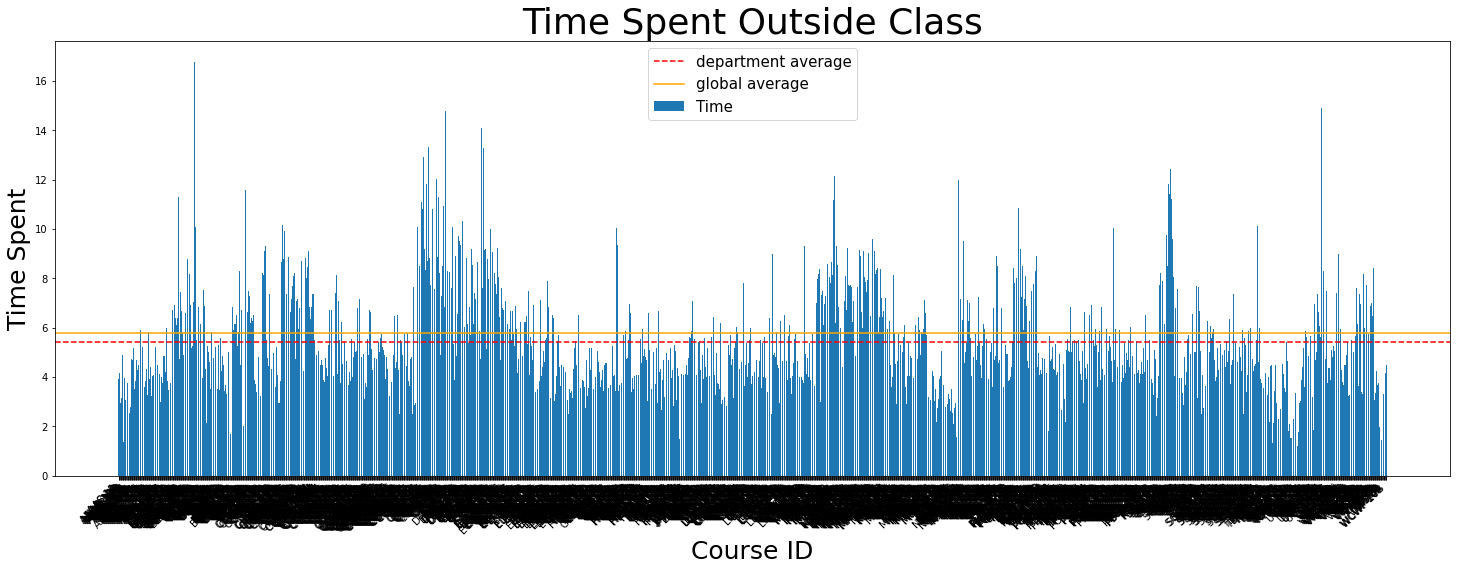

In [22]:
time_draw = time_factor_depart 

plt.figure(figsize=(25, 8))
plt.bar(time_draw['Course_ID'], time_draw['time'], label='Time')

depart_average_time = time_draw['time'].mean()
plt.axhline(y=depart_average_time, color='red', linestyle='--', label='department average')

global_average_time = time_draw['global_avg_time'].mean()
plt.axhline(y=global_average_time, color='orange', linestyle='-', label='global average')

plt.title('Time Spent Outside Class',fontsize=36)
plt.xlabel('Course ID',fontsize=25)
plt.ylabel('Time Spent',fontsize=25)

plt.xticks(rotation=45, ha='right',fontsize=10)
plt.yticks(fontsize=10)

plt.legend(fontsize=15)
plt.show()

In [23]:
# factor 2: difference between actual gpa and expected gpa
grade_dev_factor = get_grade_dev_df(df_quarter)
grade_dev_factor_depart = grade_dev_factor[grade_dev_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True) # should be changed later for different inputs
# grade_dev_factor_depart = grade_dev_factor.loc[time_factor.index.str.startswith('ECE')].copy()  
print(grade_dev_factor_depart)
dev=pd.DataFrame(grade_dev_factor_depart)
dev

     Course_ID  expected_gpa  actual_gpa   dev
0       AAS 10          3.76        3.62 -0.14
1       AAS 11          3.84        3.71 -0.13
2      AAS 170          3.89        3.68 -0.21
3      AAS 190          3.86        4.00  0.14
4     ANAR 100          3.33        3.30 -0.03
...        ...           ...         ...   ...
1854    VIS 83          3.79        3.62 -0.17
1855    VIS 84          3.83        3.84  0.01
1856  WCWP 100          3.57        3.52 -0.05
1857  WCWP 10A          3.71        3.59 -0.12
1858  WCWP 10B          3.70        3.65 -0.05

[1859 rows x 4 columns]


Course_ID  expected_gpa  actual_gpa   dev
0       AAS 10          3.76        3.62 -0.14
1       AAS 11          3.84        3.71 -0.13
2      AAS 170          3.89        3.68 -0.21
3      AAS 190          3.86        4.00  0.14
4     ANAR 100          3.33        3.30 -0.03
...        ...           ...         ...   ...
1854    VIS 83          3.79        3.62 -0.17
1855    VIS 84          3.83        3.84  0.01
1856  WCWP 100          3.57        3.52 -0.05
1857  WCWP 10A          3.71        3.59 -0.12
1858  WCWP 10B          3.70        3.65 -0.05

[1859 rows x 4 columns]

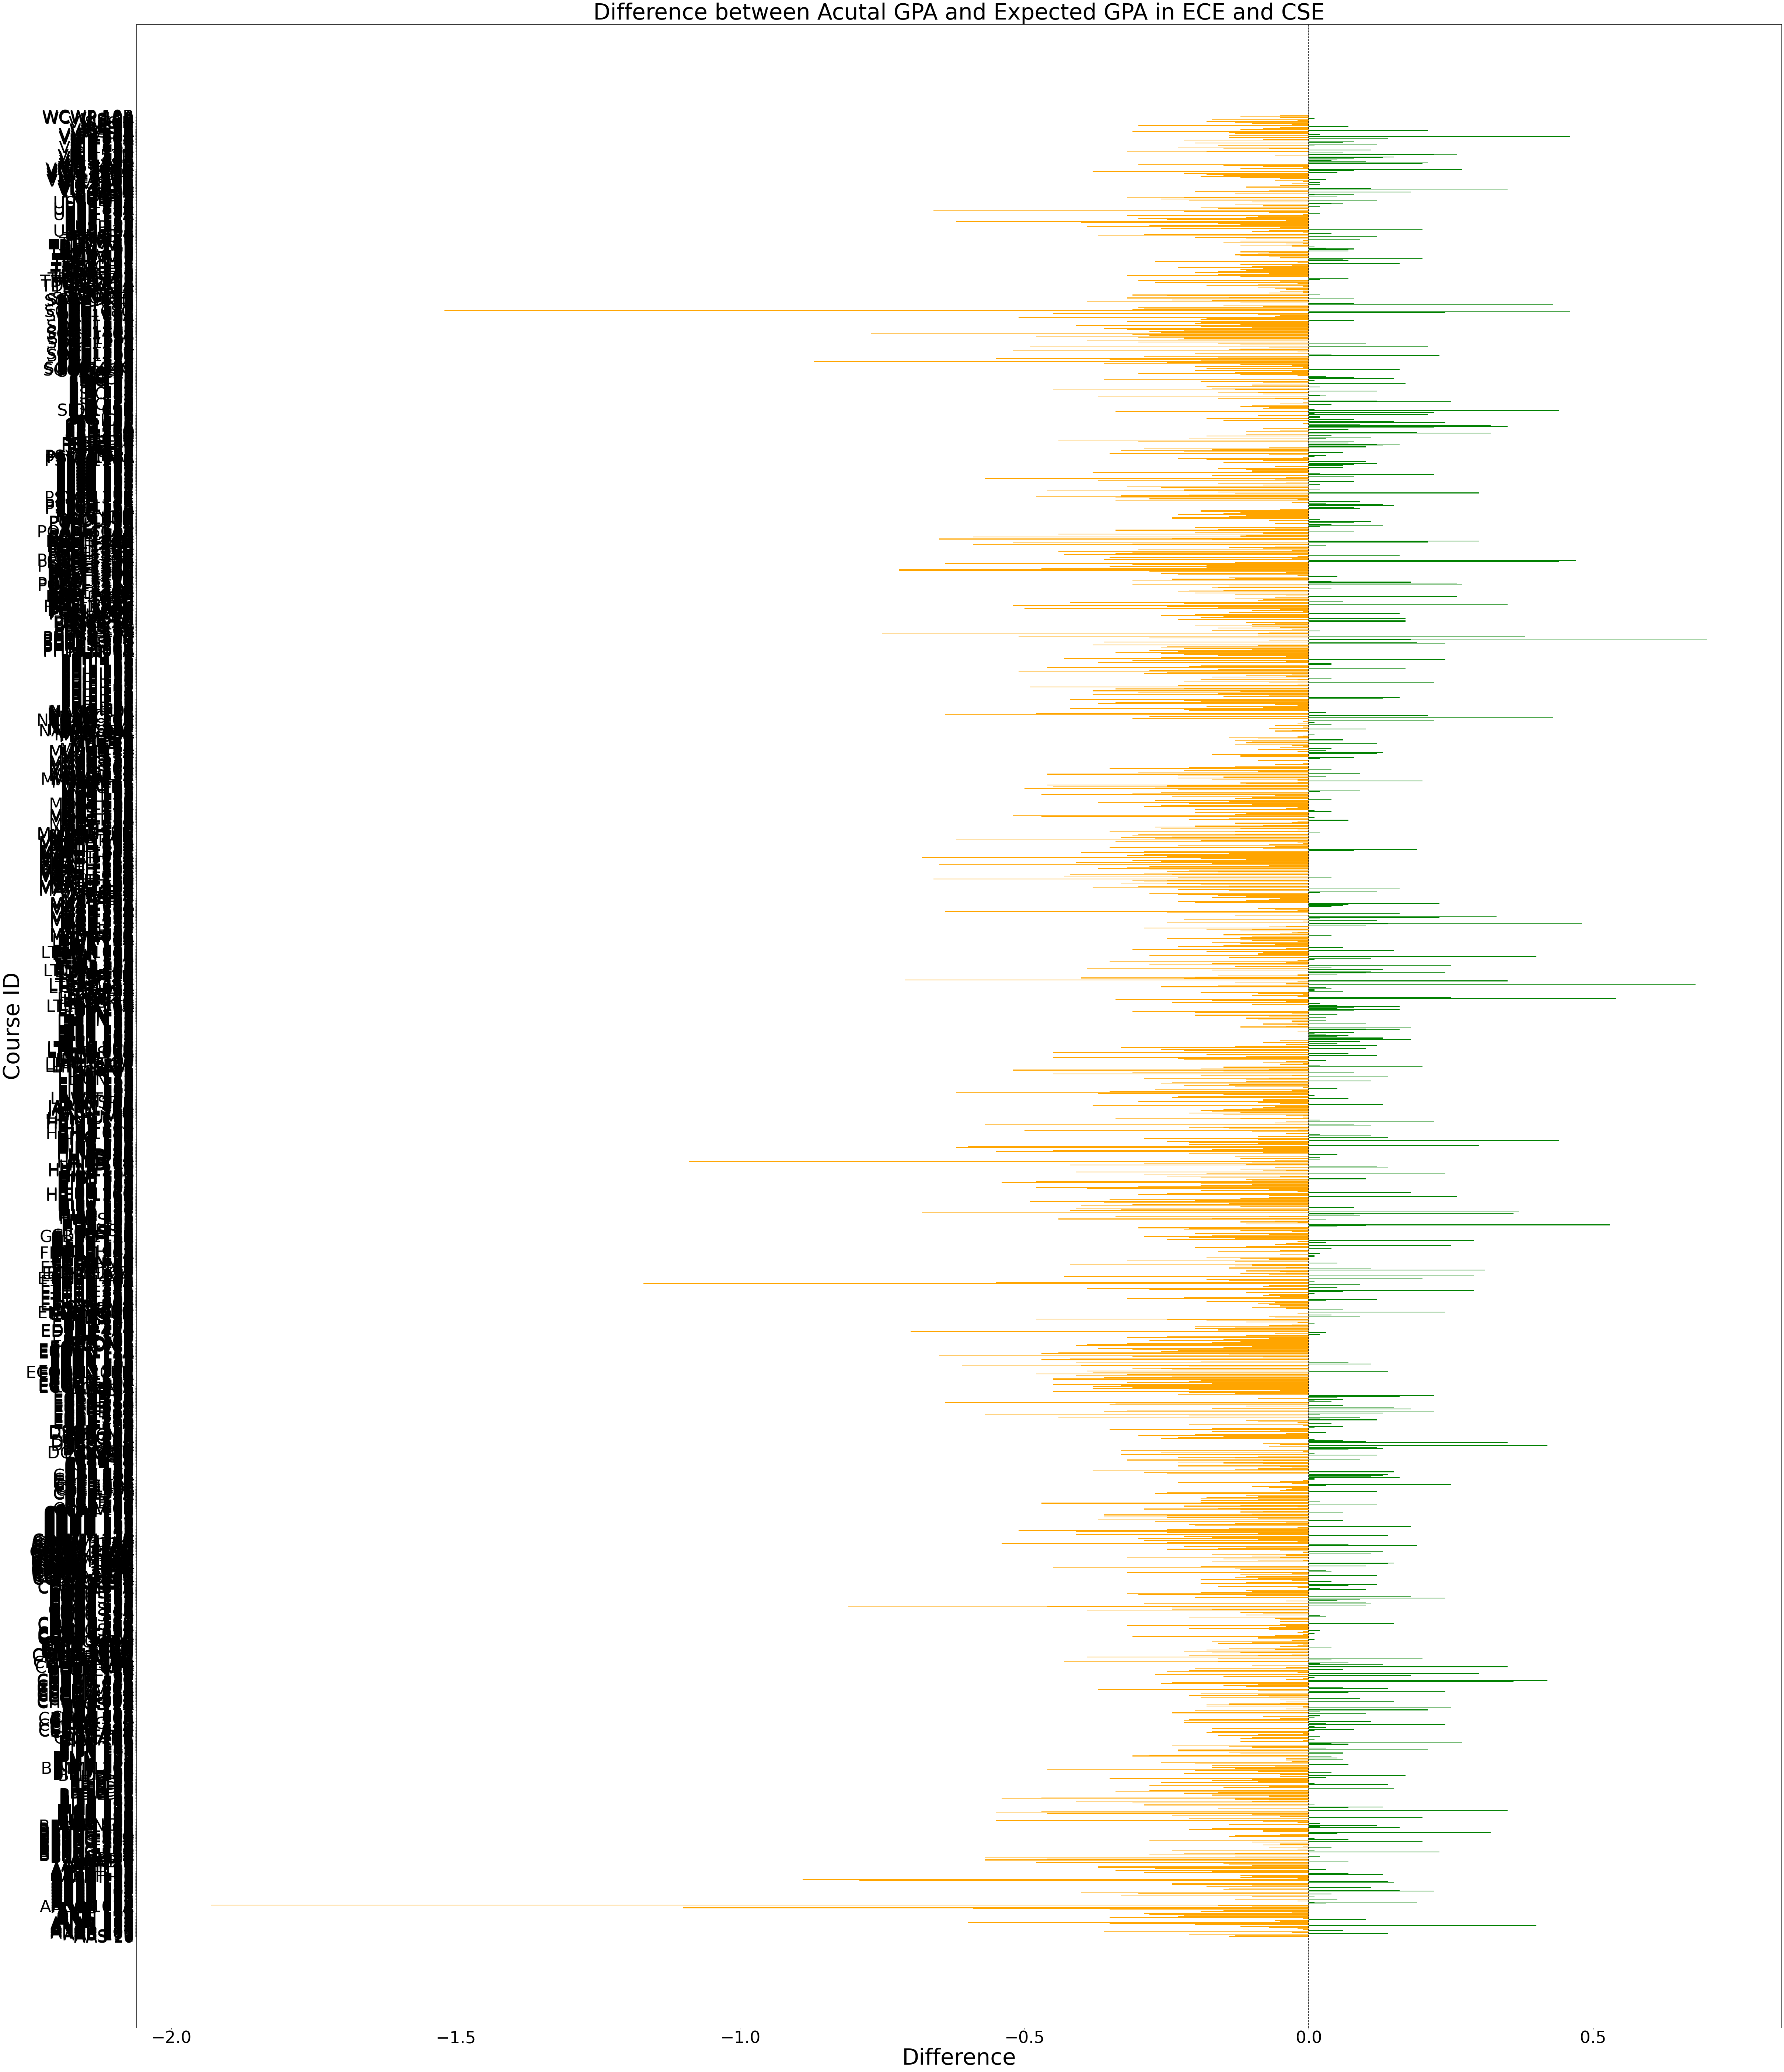

In [24]:
# Sample data
difference=list(dev['dev'])
ID=list(dev['Course_ID'])
# categories = ['Category A', 'Category B', 'Category C', 'Category D']
# values = [10, -5, 15, -8]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(80,100))
ax.barh(ID, difference, color=['green' if val >= 0 else 'orange' for val in difference])

# Add a horizontal line at y=0
ax.axvline(x=0, color='black', linestyle='--')
ax.tick_params(axis='y',labelsize=45)
ax.tick_params(axis='x',labelsize=45)
# Function to update the plot for animation
def update(frame):
    ax.clear()
    ax.barh(ID, difference, color=['green' if val >= 0 else 'orange' for val in difference])
    ax.axvline(x=0, color='black', linestyle='--')
    ax.set_xlim(-15, 15)  # Adjust the x-axis limits as needed
    ax.set_title('Frame: {}'.format(frame))

# Create the animation

animation = FuncAnimation(fig, update, frames=np.arange(0, 100), interval=200)
plt.title('Difference between Acutal GPA and Expected GPA in ECE and CSE',fontsize=60)
plt.xlabel('Difference',fontsize=60)
plt.ylabel('Course ID',fontsize=60)
plt.show()


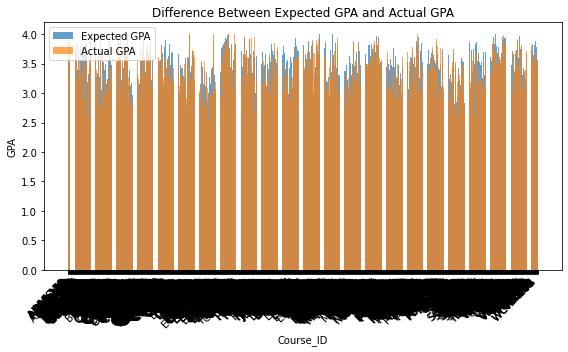

In [25]:
grade_dev_draw = grade_dev_factor_depart  

plt.figure(figsize=(8, 5))
difference=list(dev['dev'])
ID=list(dev['Course_ID'])
plt.bar(grade_dev_draw['Course_ID'], grade_dev_draw['expected_gpa'], label='Expected GPA', alpha=0.7)
plt.bar(grade_dev_draw['Course_ID'], grade_dev_draw['actual_gpa'], label='Actual GPA', alpha=0.7)


plt.title('Difference Between Expected GPA and Actual GPA')
plt.xlabel('Course_ID')
plt.ylabel('GPA')


plt.xticks(rotation=45, ha='right')

plt.legend()

plt.tight_layout()
plt.show()

In [26]:
# factor 3: gpa got
grade_factor_depart = grade_dev_factor_depart[['actual_gpa']].copy()
print(grade_factor_depart)

      actual_gpa
0           3.62
1           3.71
2           3.68
3           4.00
4           3.30
...          ...
1854        3.62
1855        3.84
1856        3.52
1857        3.59
1858        3.65

[1859 rows x 1 columns]


In [27]:
# gpa plot will not be plotted since it is included in the gpa difference figure. We simply add it as a weight for our recommendation system

In [28]:
# factor 4: % recommend the class
class_factor = get_class_rmd_df(df_quarter)
class_factor_depart = class_factor[class_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(class_factor_depart)

     Course_ID  rmd_class
0       AAS 10      86.92
1       AAS 11      93.50
2      AAS 170      88.90
3      AAS 190     100.00
4     ANAR 100     100.00
...        ...        ...
1854    VIS 83      95.15
1855    VIS 84      88.85
1856  WCWP 100      92.43
1857  WCWP 10A      92.44
1858  WCWP 10B      89.89

[1859 rows x 2 columns]


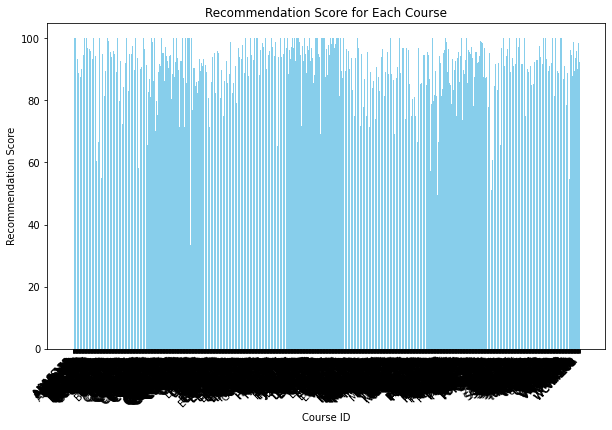

In [29]:
plt.figure(figsize=(10, 6))

plt.bar(class_factor_depart['Course_ID'], class_factor_depart['rmd_class'], color='skyblue')

plt.xlabel('Course ID')
plt.ylabel('Recommendation Score')
plt.title('Recommendation Score for Each Course')

plt.xticks(rotation=45, ha='right')

plt.show()

In [30]:
# factor 5: % recommend the instructor
instr_factor = get_instr_rmd_df(df_quarter)
instr_factor_depart = instr_factor[instr_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
print(instr_factor_depart)

     Course_ID                        instr  rmd_instr
0       AAS 10    Butler, Elizabeth Annette      90.94
1       AAS 11    Butler, Elizabeth Annette      93.30
2      AAS 170    Butler, Elizabeth Annette      88.90
3      AAS 190  Puritty, Chandler Elizabeth     100.00
4     ANAR 100                Fortier, Jana     100.00
...        ...                          ...        ...
3940  WCWP 10B            Gagnon, Jeffrey C      93.90
3941  WCWP 10B           Johnson, Eric Lynn     100.00
3942  WCWP 10B              Savage, Sarah S     100.00
3943  WCWP 10B           Tocki, Jasmine Rae     100.00
3944  WCWP 10B         Welji, Haleema Nazir      86.95

[3945 rows x 3 columns]


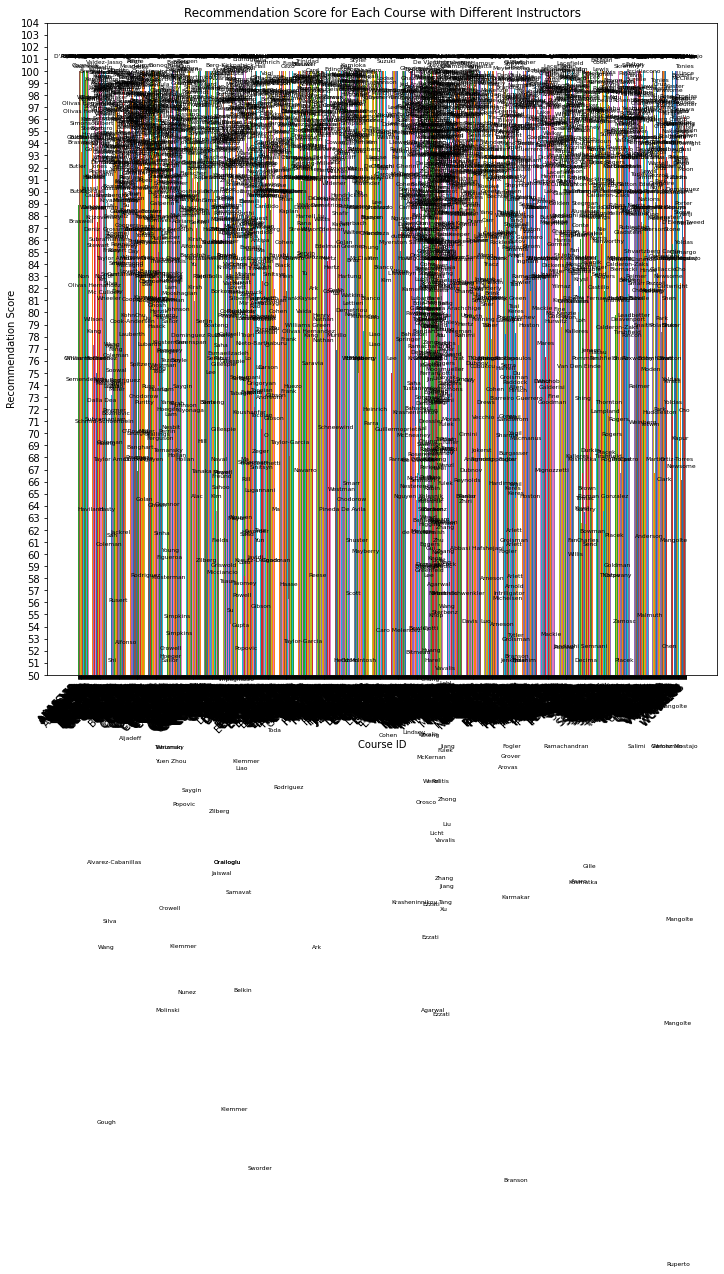

In [31]:
plt.figure(figsize=(12, 12))
for i, course_id in enumerate(instr_factor_depart['Course_ID']):
    plt.bar(course_id, instr_factor_depart['rmd_instr'].iloc[i], label=instr_factor_depart['instr'].iloc[i].split(',')[0])
    plt.text(course_id, instr_factor_depart['rmd_instr'].iloc[i] + 1, instr_factor_depart['instr'].iloc[i].split(',')[0], ha='center', va='bottom', fontsize=6)

plt.xlabel('Course ID')
plt.ylabel('Recommendation Score')
plt.title('Recommendation Score for Each Course with Different Instructors')
plt.xticks(rotation=45, ha='right')
plt.ylim(50, 100)
plt.yticks(range(50, 105))

plt.show()

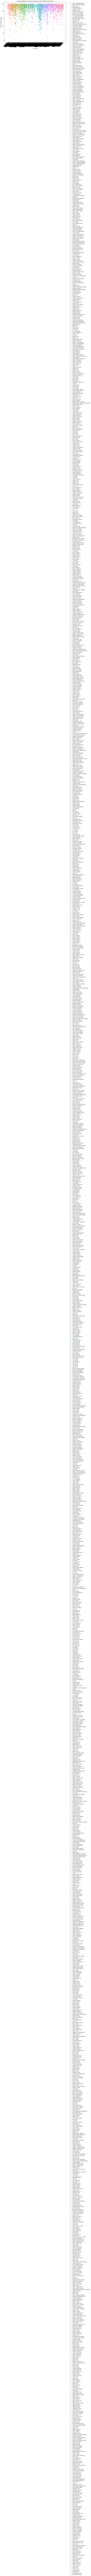

In [32]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='Course_ID', y='rmd_instr', hue='instr', data=instr_factor_depart)
plt.xlabel('Course ID')
plt.ylabel('Recommendation Score')
plt.title('Recommendation Score for Each Course with Different Instructors')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.show()

## Check if a specific class is recommended or not

Type the class you are interested in and we will let you know the best professors and if we recommend it or not

Ex. ECE 5


In [33]:
class_in = input("Type you desired class:")
class_in

KeyboardInterrupt: Interrupted by user

In [ ]:
# Creates dataframe of entries for input class id and sorts by rec_score

df_class = df_quarter[df_quarter['Course_ID'].str.contains(class_in)]
df_class_grouped = df_class.groupby('instr').mean().round(2).reset_index()
df_class_grouped = df_class_grouped.sort_values(by = 'rec_score', ascending = False).reset_index()
df_class_grouped

In [ ]:
# Presents data to user
result_2 = df_class_grouped[['instr']]

print('Based on your preferences, these are the professors ranked for ' + str(class_in)+ ': \n')
print(result_2)

In [ ]:
counts =df_quarter['instr'].value_counts()
# df_group = df_group.sort_values(by = 'rec_score', ascending = False).reset_index()
df_instructor=counts[counts>1].index.tolist()
df_instructor=df_quarter[df_quarter['instr'].isin(df_instructor)]
df_instructor.sort_values(by='instr').reset_index()


In [ ]:
df_instructor['actual_gpa'] = pd.to_numeric(df_instructor['actual_gpa'], errors='coerce')
df_instructor
plt.figure(figsize=(30, 5))
distribution_dif=sns.barplot(x='Course_ID',y='actual_gpa',hue='term',data=df_instructor)
plt.xlabel('Course ID')
plt.ylabel('Actual GPA Got')
plt.title('Distribution of Actual GPA for Course Whose Professor Teach in Different Years')
distribution_dif=sns.barplot(x='Course_ID',y='actual_gpa',hue='term',data=df_instructor)



In [ ]:
df_quarter

In [ ]:
df_S1 = df[df['term'].str.contains('S1')].reset_index(drop=True)
df_S2 = df[df['term'].str.contains('S2')].reset_index(drop=True)
df_FA = df[df['term'].str.contains('FA')].reset_index(drop=True)
df_WI = df[df['term'].str.contains('WI')].reset_index(drop=True)
df_SP = df[df['term'].str.contains('SP')].reset_index(drop=True)


In [ ]:
df_WI

In [ ]:
global_average_S1, global_std_S1 = get_global_avg_time(df_S1)
global_average_S2, global_std_S2 = get_global_avg_time(df_S2)
global_average_FA, global_std_FA = get_global_avg_time(df_FA)
global_average_WI, global_std_WI = get_global_avg_time(df_WI)
global_average_SP, global_std_SP = get_global_avg_time(df_SP)
temp_data={'Quarter':['Summer session 1','Summer session 2','Fall','Winter','Spring'],
           'Average time spent':[global_average_S1,global_average_S2,global_average_FA,global_average_WI,global_average_SP],
           'Standard deviation of time spent':[global_std_S1,global_std_S2,global_std_FA,global_std_WI,global_std_SP]
    
}
time_dif_of_summer=pd.DataFrame(temp_data)
time_dif_of_summer
# global_average_S1,global_average_S2,global_average_WI


# time_factor = get_time_df(df_S1, global_average, global_std)
# time_factor_depart = time_factor[time_factor['Course_ID'].str.contains('|'.join(depts))].copy().reset_index(drop=True)
# print(time_factor_depart)

In [ ]:
sns.set(style="whitegrid") 
plt.figure(figsize=(8, 5))
# sns.barplot(x='Quarter', y='Data_1', data=df, color='blue', label='Data 1')
# sns.barplot(x='X_values', y='Data_2', data=df, color='orange', label='Data 2')

# 添加图例
Time_quarters=sns.barplot(x='Quarter',y='Average time spent',color='green',label='Average time spent',data=time_dif_of_summer)
Std_quarters=sns.barplot(x='Quarter',y='Standard deviation of time spent',color='orange',label='Standard deviation of time spent',data=time_dif_of_summer)
plt.legend()
plt.xlabel('Quarters')
plt.ylabel('Time Spent')
plt.title('Distribution of Average Time Spent for Different Quarters')



In [ ]:
df_ECE143 = df[df['Course_ID'].str.contains('ECE 143')].reset_index(drop=True)
term_order = ['WI19','SP19','FA19', 'WI20', 'SP20', 'FA20', 'WI21', 'SP21', 'FA21', 'WI22', 'SP22', 'FA22', 'WI23', 'SP23', 'FA23']  # 自定义排序顺序
df_ECE143['term'] = pd.Categorical(df_ECE143['term'], categories=term_order, ordered=True)

One_Grade_Trend={
    
}
df_ECE143.sort_values(by='term').reset_index(drop=True)

In [ ]:
sns.set(style="whitegrid")  
plt.figure(figsize=(10, 6))  

sns.lineplot(x='term', y='expected_gpa', data=df_ECE143, marker='o',ci=85,label='Expected GPA')
sns.lineplot(x='term', y='actual_gpa', data=df_ECE143, marker='o',ci=85,label='Actual GPA')




plt.title('Expected and Actual GPA Got in Different Quarters',fontsize=16)
plt.xlabel('Quarters')
plt.ylabel('GPA Got')


plt.show()

In [ ]:
sns.relplot(x='time',y='actual_gpa',hue='expected_gpa',data=df)
plt.title('Correlation between Time Spent, Expected GPA and Actual GPA',fontsize=16)
plt.xlabel('Time spent')
plt.ylabel('Actual GPA Got')
# plt.legend(title='Expected GPA')

# plt.legend(title='Expected GPA')


In [ ]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='time', y='actual_gpa', data=df)

# 设置 x 轴和 y 轴标签
joint.set_axis_labels('Time Spent', 'Actual GPA Got')

# 设置标题
joint.fig.suptitle('Correlation between Time Spent and Actual GPA Got', y=1.05)
plt.show()

In [ ]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='time', y='actual_gpa', data=df_quarter)

# 设置 x 轴和 y 轴标签
joint.set_axis_labels('Time Spent', 'Actual GPA Got')

# 设置标题
joint.fig.suptitle('Correlation between Time Spent and Actual GPA Got in ECE', y=1.05)
plt.show()

In [ ]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='time', y='rmd_class', data=df)

# 设置 x 轴和 y 轴标签
joint.set_axis_labels('Time Spent', 'Recommending Rate of Particular Class')

# 设置标题
joint.fig.suptitle('Correlation between Time Spent and Recommending Rate of Particular Class', y=1.05)
plt.show()

In [ ]:
plt.figure(figsize=(16, 5))
joint = sns.jointplot(x='actual_gpa', y='rmd_class', data=df)

# 设置 x 轴和 y 轴标签
joint.set_axis_labels('Actual GPA Got', 'Recommending Rate of Particular Class')

# 设置标题
joint.fig.suptitle('Correlation between Actual GPA Got and Recommending Rate of Particular Class', y=1.05)
plt.show()

In [ ]:
# sns.jointplot(x='actual_gpa',y='rmd_class',data=df)

In [ ]:
df_worst=df_quarter.sort_values(by='rmd_class').reset_index(drop=True)


In [ ]:
df_worst_50=df_worst.head(50)
df_worst_50

In [ ]:
sns.relplot(x='time', y='actual_gpa', hue='rmd_class', data=df_worst_50)

# 设置 x 轴和 y 轴标签
plt.xlabel('Time Spent')
plt.ylabel('Actual GPA Got')
plt.title('Effection of Time Spent and Actual GPA to Recommending Rate of the Worst 50 Classes in ECE')
# 修改图例中 'rmd_class' 的标签名称为 'Recommend'
# plt.legend(title='Recommending Rate',loc='upper right')

In [ ]:
df_best=df_quarter.sort_values(by='rmd_class',ascending=False).reset_index(drop=True)
df_best_50=df_best.head(50)
df_best_50

In [ ]:
sns.relplot(x='time',y='actual_gpa',hue='rmd_class',data=df_best_50)
plt.xlabel('Time Spent')
plt.ylabel('Actual GPA Got')
plt.title('Effection of Time Spent and Actual GPA to Recommending Rate of the Best 50 Classes in ECE')

In [ ]:
x = get_depts_and_courses_dictionary(df)
x.keys()
